We are going to use the Google Colab platform as they provide free GPU

The aim of this project is to build a image classification system which will aid in assessing the severity of damage to properties (buildings/houses, roads, bridges) primarily during natural disasters.
The primary dataset has been obtained from:https://crisisnlp.qcri.org/
The secondary dataset has been built with images obtained from flickr using their APIs.

In [0]:
#commenting the below 2 lines as it contains information related to my Google account
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
import zipfile
from zipfile import ZipFile
import tarfile
import pandas as pd
import numpy as np
import os, shutil
from math import ceil, floor
from IPython.display import display
from PIL import Image

In [0]:
def unzip_files(zipFilePath, unzip_directory):
  zipFile = ZipFile(zipFilePath, 'r')
  zipFile.extractall(unzip_directory)
  zipFile.close()
    
def delete_file_directory(path, isDirectory):
  if isDirectory:
    shutil.rmtree(path)
  else:
    os.remove(path)

In [0]:
def handle_tarfile(filePath):
  
  if filePath.endswith('tar.gz'):
    tarContent = tarfile.open(filePath, "r:gz")
  else:
    tarContent = tarfile.open(filePath, "r:")

  tarContent.extractall()
  tarContent.close()

In [0]:
handle_tarfile('drive/My Drive/datasets/damage_during_natural_disasters/CrisisMMD_v1.0.tar.gz')

In this project we are interested in assessing the damage caused to properties during natural disasters. We are going to do image classification to solve the problem.

let us read one of the tsv files from the annotations folder in order to understand the contents of the dataset and how to go ahead with solving the problem

In [0]:
example_df = pd.read_csv('annotations/hurricane_harvey_final_data.tsv', sep='\t')

In [11]:
example_df.head(10)

tweet_id  ...                                         image_path
0  905274232590004225  ...  data_image/hurricane_harvey/27_8_2017/90167168...
1  901646074527535105  ...  data_image/hurricane_harvey/27_8_2017/90164607...
2  901646074527535105  ...  data_image/hurricane_harvey/27_8_2017/90164607...
3  901646074527535105  ...  data_image/hurricane_harvey/27_8_2017/90164607...
4  901646074527535105  ...  data_image/hurricane_harvey/27_8_2017/90164607...
5  901646123080830976  ...  data_image/hurricane_harvey/27_8_2017/90164612...
6  901646123080830976  ...  data_image/hurricane_harvey/27_8_2017/90164612...
7  901646123080830976  ...  data_image/hurricane_harvey/27_8_2017/90164612...
8  901646123080830976  ...  data_image/hurricane_harvey/27_8_2017/90164612...
9  901646127895863296  ...  data_image/hurricane_harvey/27_8_2017/90164612...

[10 rows x 15 columns]

In [12]:
#checking the number of records
len(example_df)

4443

We are particularly interested in the "image_damage" and "image_path" columns for the current project

In [13]:
example_df['image_damage'].value_counts()

severe_damage              556
mild_damage                222
little_or_no_damage        116
dont_know_or_cant_judge     22
Name: image_damage, dtype: int64

for the current project, we will be interested in records which have a value for "image_damage" and filter out records which have an empty or NaN value for "image_damage"

Let us count the number of NaN values in "image_damage" column

In [14]:
example_df['image_damage'].isna().sum()

3527

We will be following the below approach:
1. Let us create a main folder (all_disaster_images) and inside that 3 folders (severe_damage, mild_damage, little_or_no_damage), which will contain the images pertaining to each severity of damage
2. We will go through all the tsv files pertaining to different natural disasters in the annotations folder
3. Records which have valid "image_damage" values, we will copy the image from the "image_path" and paste it in one of the 3 folders created above based on the "image_damage" type 

In [0]:
severity_levels = ["severe_damage", "mild_damage", "little_or_no_damage"]

In [0]:
base_dir = 'all_disaster_images'
os.mkdir(base_dir)

In [0]:
for cur_level in severity_levels:
  cur_dir = os.path.join(base_dir, cur_level)
  os.mkdir(cur_dir)

In [0]:
tsv_files = os.listdir('annotations/')

In [19]:
for cur_file in tsv_files:
  print('current tsv file:', cur_file)
  cur_df = pd.read_csv('annotations/' + cur_file, sep='\t')
  print('number of records', len(cur_df))
  print('counts\n', cur_df['image_damage'].value_counts())
  print('number of NaN records', cur_df['image_damage'].isna().sum())
  #we will be dropping rows which have NaN values in "image_damage" column
  cur_df = cur_df.dropna(subset=['image_damage'])
  print('updated number of records', len(cur_df))
  for i, row in cur_df.iterrows():
    image_damage_type = row['image_damage']
    if image_damage_type != 'dont_know_or_cant_judge':
      src = row['image_path']
      index = src.rfind('/') + 1
      img_name = src[index:]
      dst = 'all_disaster_images/' + image_damage_type + '/' + img_name
      shutil.copyfile(src, dst)
      img = Image.open(dst)
      img = img.convert('RGB')
      img = img.resize((256, 256))
      img.save(dst, 'JPEG')
  print("===========================================================")

current tsv file: mexico_earthquake_final_data.tsv
number of records 1382
counts
 severe_damage              148
mild_damage                 25
little_or_no_damage          5
dont_know_or_cant_judge      4
Name: image_damage, dtype: int64
number of NaN records 1200
updated number of records 182
current tsv file: iraq_iran_earthquake_final_data.tsv
number of records 600
counts
 severe_damage          158
mild_damage             11
little_or_no_damage      4
Name: image_damage, dtype: int64
number of NaN records 427
updated number of records 173
current tsv file: hurricane_maria_final_data.tsv
number of records 4562
counts
 severe_damage              509
mild_damage                273
little_or_no_damage         80
dont_know_or_cant_judge     42
Name: image_damage, dtype: int64
number of NaN records 3658
updated number of records 904
current tsv file: hurricane_irma_final_data.tsv
number of records 4525
counts
 severe_damage              320
little_or_no_damage        250
mild_damage    

In [20]:
#let us check the number of images in each damage_type
for cur_level in severity_levels:
  cur_dir = os.path.join(base_dir, cur_level)
  print("Number of images in {} category is {}".format(cur_level, len(os.listdir(cur_dir))))

Number of images in severe_damage category is 2212
Number of images in mild_damage category is 840
Number of images in little_or_no_damage category is 475


As we can see little_or_no_damage category has less number of images, this can lead to class imbalance. To overcome this till sone extend, I have obtained additional images from flickr. To see how i have obtained images from flickr via their APIs, please refer the 'flickr_imgs' python notebook. 

In [0]:
unzip_files('drive/My Drive/datasets/damage_during_natural_disasters/flickr_damage_imgs.zip', 'Unzipped_flickr_damage_imgs')

In [0]:
base_flickr_dir = 'Unzipped_flickr_damage_imgs/flickr_damage_imgs/'

Let us check the number of images obtained from flickr in each severity category

In [23]:
for cur_level in severity_levels:
  cur_dir = os.path.join(base_flickr_dir, cur_level)
  print("Number of images in {} category is {}".format(cur_level, len(os.listdir(cur_dir))))

Number of images in severe_damage category is 105
Number of images in mild_damage category is 152
Number of images in little_or_no_damage category is 949


In [0]:
def display_sample_imgs(path):
  for cur_severity_level in severity_levels:
    print('current severity level:', cur_severity_level)
    cur_severity_dir = path + cur_severity_level
    cur_imgs = os.listdir(path + cur_severity_level)[:4]
    canvas_sheet_width = 1184
    canvas_sheet_height = 320
    canvas_sheet = Image.new('RGB', (canvas_sheet_width, canvas_sheet_height))
    x = 32
    for cur_img in cur_imgs:
      img = Image.open(cur_severity_dir + '/' + cur_img)
      img = img.resize((256,256))
      canvas_sheet.paste(img, (x, 32))
      x += 256 + 32
    display(canvas_sheet)

Let us see the sample images that are in the primary dataset obtained from the crisisnlp website

current severity level: severe_damage


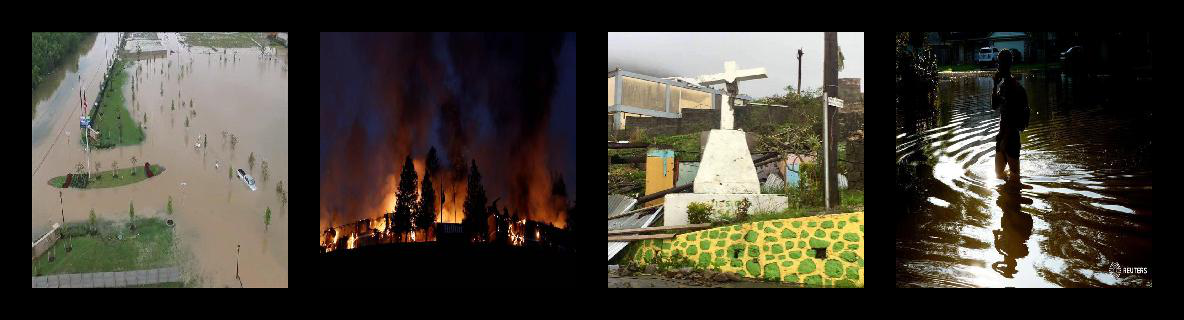

current severity level: mild_damage


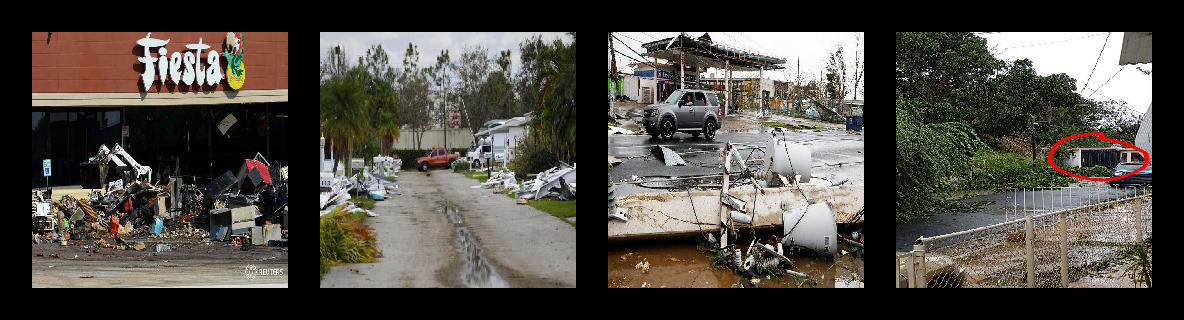

current severity level: little_or_no_damage


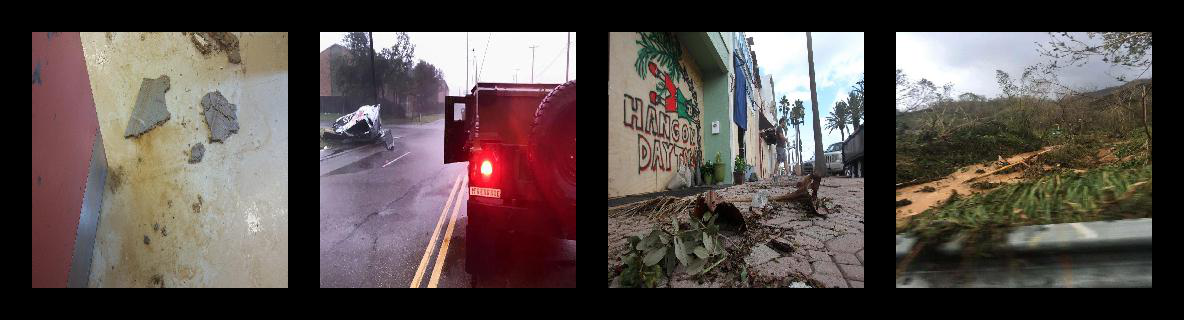

In [26]:
display_sample_imgs('all_disaster_images/')

Let us check the sample images obtained from flickr

current severity level: severe_damage


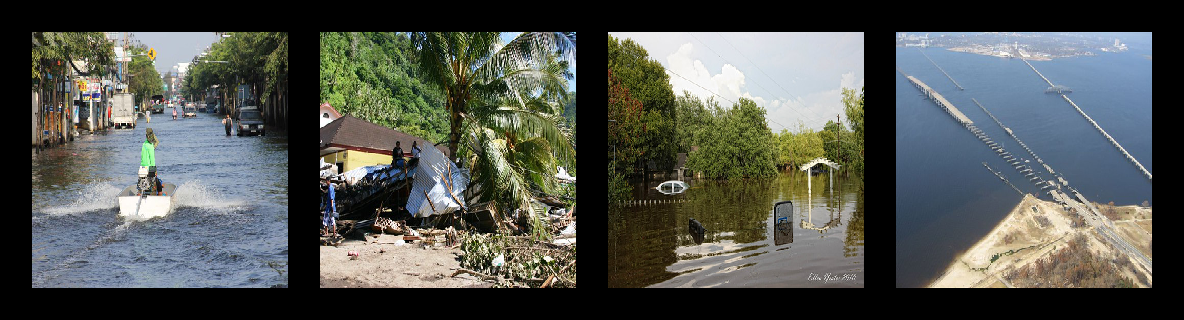

current severity level: mild_damage


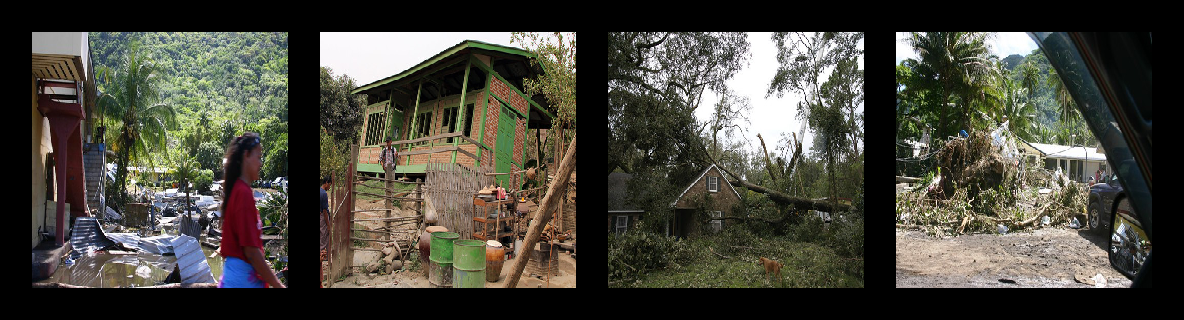

current severity level: little_or_no_damage


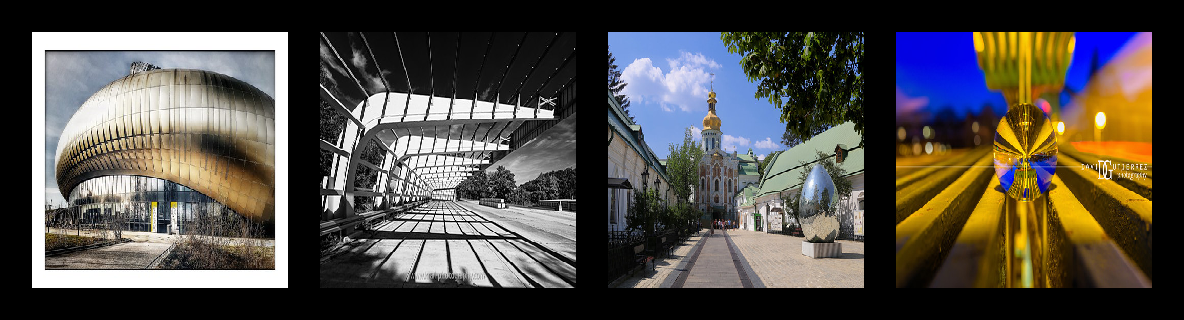

In [27]:
display_sample_imgs('Unzipped_flickr_damage_imgs/flickr_damage_imgs/')

Now we need to merge these datasets obtained from different sources

We will be copying all the images obtained from flickr into the 'all_disaster_imgs' folder based on the different severity level of damage

In [0]:
for cur_severity_level in severity_levels:
  cur_severity_dir = base_flickr_dir + cur_severity_level
  cur_imgs = os.listdir(base_flickr_dir + cur_severity_level)
  for cur_img in cur_imgs:
    img = Image.open(cur_severity_dir + '/' + cur_img)
    img = img.convert('RGB')
    img = img.resize((256,256))
    img.save('all_disaster_images/' + cur_severity_level + '/' + cur_img, 'JPEG')

After combining the datasets let us check the total number of images in each severity category

In [29]:
for cur_level in severity_levels:
  cur_dir = os.path.join(base_dir, cur_level)
  print("Number of images in {} category is {}".format(cur_level, len(os.listdir(cur_dir))))

Number of images in severe_damage category is 2317
Number of images in mild_damage category is 992
Number of images in little_or_no_damage category is 1424


Now we need to split the entire dataset in train(80%), validation(10%), test (10%). The splitting ratio is approximate.

In [0]:
assessment_dirs = ['TRAIN', 'TEST', 'VAL']

Let us create these directories 

In [0]:
for cur_dir in assessment_dirs:
  new_dir = os.path.join(base_dir, cur_dir)
  os.mkdir(new_dir)

each of the assessment directories will have 3 sub-directories (severe damage, mild damage, little or no damage)

In [0]:
for cur_dir in assessment_dirs:
  full_path = os.path.join(base_dir, cur_dir)
  for cur_level in severity_levels:
    new_dir = os.path.join(full_path, cur_level)
    os.mkdir(new_dir)

In [0]:
def move_files(base_src, base_dst, steps=1):
  for cur_severity_level in severity_levels:
    print('current severity level', cur_severity_level)
    cur_imgs = os.listdir(base_src + '/' + cur_severity_level)
    num_of_imgs = len(cur_imgs)
    print('number of images', num_of_imgs)
    for i in range(0, num_of_imgs, steps):
      cur_img = cur_imgs[i]
      src = base_src + '/' + cur_severity_level + '/' + cur_img
      dst = base_dst + '/' + cur_severity_level + '/' + cur_img
      shutil.move(src, dst)

In [34]:
move_files(base_dir, base_dir + '/' + 'VAL', 10)

current severity level severe_damage
number of images 2317
current severity level mild_damage
number of images 992
current severity level little_or_no_damage
number of images 1424


In [35]:
move_files(base_dir, base_dir + '/' + 'TEST', 9)

current severity level severe_damage
number of images 2085
current severity level mild_damage
number of images 892
current severity level little_or_no_damage
number of images 1281


In [36]:
move_files(base_dir, base_dir + '/' + 'TRAIN', 1)

current severity level severe_damage
number of images 1853
current severity level mild_damage
number of images 792
current severity level little_or_no_damage
number of images 1138


In [37]:
total_train_imgs = 0
total_test_imgs = 0
total_val_imgs = 0
for cur_dir in assessment_dirs:
    for cur_severity_level in severity_levels:
        num_of_imgs = len(os.listdir(base_dir + '/' + cur_dir + '/' + cur_severity_level))
        if cur_dir == 'TRAIN':
            total_train_imgs += num_of_imgs
        elif cur_dir == 'TEST':
            total_test_imgs += num_of_imgs
        else:
            total_val_imgs += num_of_imgs
            
print('total training images', total_train_imgs)
print('total test images', total_test_imgs)
print('total val images', total_val_imgs)

total training images 3783
total test images 475
total val images 475


In [38]:
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
train_dir = 'all_disaster_images/TRAIN'
val_dir = 'all_disaster_images/VAL'
test_dir = 'all_disaster_images/TEST'

In [41]:
batch_size = 32
steps_per_epoch = floor(total_train_imgs/batch_size)
validation_steps = floor(total_val_imgs/batch_size)
test_steps = floor(total_test_imgs/batch_size)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print('test_steps', test_steps)

steps_per_epoch 118
validation_steps 14
test_steps 14


In [0]:
def get_train_datagen(augmentData):
  if augmentData:
    return ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=25,
            width_shift_range=0.25,
            height_shift_range=0.25,
            shear_range=0.25,
            zoom_range=0.25,
            horizontal_flip=True,
            fill_mode='nearest'
            )
  else:
    return ImageDataGenerator(rescale=1.0/255)
  
def get_val_datagen():
  return ImageDataGenerator(rescale=1.0/255)
  
def get_test_datagen():
  return ImageDataGenerator(rescale=1.0/255)

In [0]:
def handle_model_fit_gen(model, num_epochs, train_generator, validation_generator):
  
  history_data = model.fit_generator(
      train_generator, 
      steps_per_epoch=steps_per_epoch, 
      epochs=num_epochs, 
      validation_data=validation_generator, 
      validation_steps=validation_steps)
  return history_data

In [0]:
import seaborn as sns

def create_line_charts(df, title, xlabel, ylabel):
  ax = sns.lineplot(data=df)
  ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
  
def create_acc_df(history_data, num_epochs):
  epochs_val = list(range(1, num_epochs+1))
  acc_val = history_data.history['acc']
  validation_acc_val = history_data.history['val_acc']
  acc_dict = {
      'epochs':epochs_val,
      'train_acc':acc_val,
      'val_acc':validation_acc_val
  }
  acc_df = pd.DataFrame(acc_dict)
  acc_df.set_index('epochs', inplace=True)
  return acc_df

def create_loss_df(history_data, num_epochs):
  epochs_val = list(range(1, num_epochs+1))
  loss_val = history_data.history['loss']
  validation_loss_val = history_data.history['val_loss']
  loss_dict = {
      'epochs':epochs_val,
      'train_loss':loss_val,
      'val_loss':validation_loss_val
  }
  loss_df = pd.DataFrame(loss_dict)
  loss_df.set_index('epochs', inplace=True)
  return loss_df

In [0]:
from keras.applications import VGG19

In [0]:
def get_VGG19_Conv_Base(input_shape):
  return VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

In [47]:
conv_base1 = get_VGG19_Conv_Base((256,256,3))





80142336/80134624 [==============================] - 7s 0us/step




In [48]:
conv_base1.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [49]:
custom_model1 = models.Sequential()
custom_model1.add(conv_base1)
custom_model1.add(layers.Flatten())
custom_model1.add(layers.Dropout(rate=0.3))
custom_model1.add(layers.Dense(512, activation='relu'))
custom_model1.add(layers.Dropout(rate=0.4))
custom_model1.add(layers.Dense(3, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [50]:
custom_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 36,803,651
Trainable params: 36,803,651
Non-trainable params: 0
__________________________________________

In [51]:
print('number of trainable weights before freezing the conv base', len(custom_model1.trainable_weights))
conv_base1.trainable = False
print('number of trainable weights after freezing the conv base', len(custom_model1.trainable_weights))

number of trainable weights before freezing the conv base 36
number of trainable weights after freezing the conv base 4


In [52]:
custom_model1.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['accuracy'])

In [53]:
train_datagen1 = get_train_datagen(True)
validation_datagen1 = get_val_datagen()
test_datagen1 = get_test_datagen()

train_generator1 = train_datagen1.flow_from_directory(train_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')
validation_generator1 = validation_datagen1.flow_from_directory(val_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')

Found 3783 images belonging to 3 classes.
Found 475 images belonging to 3 classes.


In [54]:
model_history_data1 = handle_model_fit_gen(custom_model1, 75, train_generator1, validation_generator1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/75
118/118 [==============================] - 62s 523ms/step - loss: 1.1684 - acc: 0.4449 - val_loss: 0.9516 - val_acc: 0.5513
Epoch 2/75
118/118 [==============================] - 59s 497ms/step - loss: 1.0371 - acc: 0.4893 - val_loss: 0.9228 - val_acc: 0.5756
Epoch 3/75
118/118 [==============================] - 56s 475ms/step - loss: 0.9931 - acc: 0.5295 - val_loss: 0.9302 - val_acc: 0.5508
Epoch 4/75
118/118 [==============================] - 56s 477ms/step - loss: 0.9614 - acc: 0.5545 - val_loss: 0.9347 - val_acc: 0.5756
Epoch 5/75
118/118 [==============================] - 55s 463ms/step - loss: 0.9683 - acc: 0.5533 - val_loss: 0.9011 - val_acc: 0.5734
Epoch 6/75
118/118 [==============================] - 56s 471ms/step - loss: 0.9438 - acc: 0.5599 - val_loss: 0.8834 - val_acc: 0.6072
Epoch 7/75
118/118 [==============================] - 55s 467ms/step - loss: 0.9392 - acc: 0.563

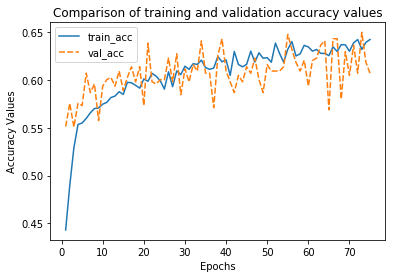

In [55]:
create_line_charts(create_acc_df(model_history_data1, 75), 'Comparison of training and validation accuracy values', 'Epochs', 'Accuracy Values')

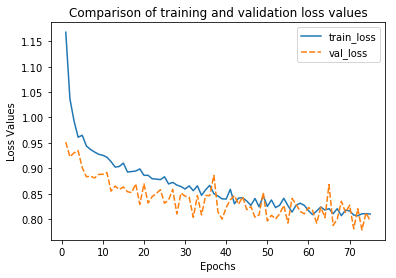

In [56]:
create_line_charts(create_loss_df(model_history_data1, 75), 'Comparison of training and validation loss values', 'Epochs', 'Loss Values')

In [57]:
test_generator1 = test_datagen1.flow_from_directory(test_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')
test_loss1, test_accuracy1 = custom_model1.evaluate_generator(test_generator1, steps=test_steps)
print('test_loss', test_loss1)
print('test_accuracy', test_accuracy1)

Found 475 images belonging to 3 classes.
test_loss 0.8446643395083291
test_accuracy 0.6138392857142857


Now let us try fine tuning the convnet layers to see whether we can improve upon the existing results.

In [0]:
conv_base2 = get_VGG19_Conv_Base((256,256,3))

In [0]:
def print_layer_details(conv_base):
  for layer in conv_base.layers:
    print('layer name:', layer.name)
    print('layer trainable:', layer.trainable)

In [0]:
def fine_tune_conv_base_block(conv_base, block_name_start):
  trainable = False
  for layer in conv_base.layers:
    if layer.name.startswith(block_name_start):
      trainable = True
    layer.trainable = trainable

In [61]:
print_layer_details(conv_base2)

layer name: input_2
layer trainable: False
layer name: block1_conv1
layer trainable: True
layer name: block1_conv2
layer trainable: True
layer name: block1_pool
layer trainable: True
layer name: block2_conv1
layer trainable: True
layer name: block2_conv2
layer trainable: True
layer name: block2_pool
layer trainable: True
layer name: block3_conv1
layer trainable: True
layer name: block3_conv2
layer trainable: True
layer name: block3_conv3
layer trainable: True
layer name: block3_conv4
layer trainable: True
layer name: block3_pool
layer trainable: True
layer name: block4_conv1
layer trainable: True
layer name: block4_conv2
layer trainable: True
layer name: block4_conv3
layer trainable: True
layer name: block4_conv4
layer trainable: True
layer name: block4_pool
layer trainable: True
layer name: block5_conv1
layer trainable: True
layer name: block5_conv2
layer trainable: True
layer name: block5_conv3
layer trainable: True
layer name: block5_conv4
layer trainable: True
layer name: block5_po

In [0]:
fine_tune_conv_base_block(conv_base2, 'block4')

In [63]:
print_layer_details(conv_base2)

layer name: input_2
layer trainable: False
layer name: block1_conv1
layer trainable: False
layer name: block1_conv2
layer trainable: False
layer name: block1_pool
layer trainable: False
layer name: block2_conv1
layer trainable: False
layer name: block2_conv2
layer trainable: False
layer name: block2_pool
layer trainable: False
layer name: block3_conv1
layer trainable: False
layer name: block3_conv2
layer trainable: False
layer name: block3_conv3
layer trainable: False
layer name: block3_conv4
layer trainable: False
layer name: block3_pool
layer trainable: False
layer name: block4_conv1
layer trainable: True
layer name: block4_conv2
layer trainable: True
layer name: block4_conv3
layer trainable: True
layer name: block4_conv4
layer trainable: True
layer name: block4_pool
layer trainable: True
layer name: block5_conv1
layer trainable: True
layer name: block5_conv2
layer trainable: True
layer name: block5_conv3
layer trainable: True
layer name: block5_conv4
layer trainable: True
layer name

In [0]:
custom_model2 = models.Sequential()
custom_model2.add(conv_base2)
custom_model2.add(layers.Flatten())
custom_model2.add(layers.Dropout(rate=0.3))
custom_model2.add(layers.Dense(512, activation='relu'))
custom_model2.add(layers.Dropout(rate=0.4))
custom_model2.add(layers.Dense(3, activation='softmax'))

In [65]:
custom_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 36,803,651
Trainable params: 34,478,083
Non-trainable params: 2,325,568
__________________________________

In [66]:
print('number of trainable weights', len(custom_model2.trainable_weights))

number of trainable weights 20


In [67]:
train_datagen2 = get_train_datagen(True)
validation_datagen2 = get_val_datagen()
test_datagen2 = get_test_datagen()

train_generator2 = train_datagen2.flow_from_directory(train_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')
validation_generator2 = validation_datagen2.flow_from_directory(val_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')

Found 3783 images belonging to 3 classes.
Found 475 images belonging to 3 classes.


In [0]:
custom_model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['accuracy'])

In [69]:
model_history_data2 = handle_model_fit_gen(custom_model2, 60, train_generator2, validation_generator2)

Epoch 1/60
118/118 [==============================] - 64s 541ms/step - loss: 1.1350 - acc: 0.4422 - val_loss: 1.0283 - val_acc: 0.4866
Epoch 2/60
118/118 [==============================] - 62s 527ms/step - loss: 1.0374 - acc: 0.4898 - val_loss: 0.9822 - val_acc: 0.5079
Epoch 3/60
118/118 [==============================] - 60s 510ms/step - loss: 1.0136 - acc: 0.5034 - val_loss: 0.9776 - val_acc: 0.5372
Epoch 4/60
118/118 [==============================] - 60s 513ms/step - loss: 0.9868 - acc: 0.5326 - val_loss: 0.9820 - val_acc: 0.5079
Epoch 5/60
118/118 [==============================] - 60s 508ms/step - loss: 0.9518 - acc: 0.5532 - val_loss: 0.8963 - val_acc: 0.6072
Epoch 6/60
118/118 [==============================] - 61s 514ms/step - loss: 0.9253 - acc: 0.5763 - val_loss: 0.9109 - val_acc: 0.5688
Epoch 7/60
118/118 [==============================] - 59s 498ms/step - loss: 0.8768 - acc: 0.6086 - val_loss: 0.8540 - val_acc: 0.5914
Epoch 8/60
118/118 [==============================] - 6

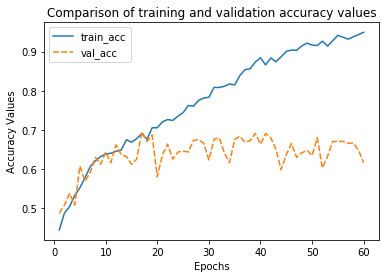

In [70]:
create_line_charts(create_acc_df(model_history_data2, 60), 'Comparison of training and validation accuracy values', 'Epochs', 'Accuracy Values')

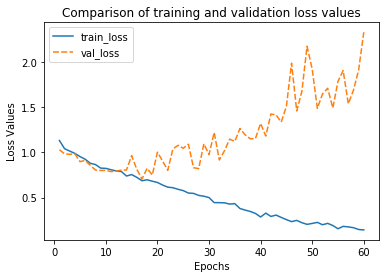

In [71]:
create_line_charts(create_loss_df(model_history_data2, 60), 'Comparison of training and validation loss values', 'Epochs', 'Loss Values')

In [72]:
test_generator2 = test_datagen2.flow_from_directory(test_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')
test_loss2, test_accuracy2 = custom_model2.evaluate_generator(test_generator2, steps=test_steps)
print('test_loss', test_loss2)
print('test_accuracy', test_accuracy2)

Found 475 images belonging to 3 classes.
test_loss 2.2907622286251614
test_accuracy 0.6116071428571429


In [0]:
conv_base3 = get_VGG19_Conv_Base((256,256,3))

In [0]:
fine_tune_conv_base_block(conv_base3, 'block5')

In [75]:
print_layer_details(conv_base3)

layer name: input_3
layer trainable: False
layer name: block1_conv1
layer trainable: False
layer name: block1_conv2
layer trainable: False
layer name: block1_pool
layer trainable: False
layer name: block2_conv1
layer trainable: False
layer name: block2_conv2
layer trainable: False
layer name: block2_pool
layer trainable: False
layer name: block3_conv1
layer trainable: False
layer name: block3_conv2
layer trainable: False
layer name: block3_conv3
layer trainable: False
layer name: block3_conv4
layer trainable: False
layer name: block3_pool
layer trainable: False
layer name: block4_conv1
layer trainable: False
layer name: block4_conv2
layer trainable: False
layer name: block4_conv3
layer trainable: False
layer name: block4_conv4
layer trainable: False
layer name: block4_pool
layer trainable: False
layer name: block5_conv1
layer trainable: True
layer name: block5_conv2
layer trainable: True
layer name: block5_conv3
layer trainable: True
layer name: block5_conv4
layer trainable: True
layer

In [0]:
custom_model3 = models.Sequential()
custom_model3.add(conv_base3)
custom_model3.add(layers.Flatten())
custom_model3.add(layers.Dropout(rate=0.3))
custom_model3.add(layers.Dense(512, activation='relu'))
custom_model3.add(layers.Dropout(rate=0.4))
custom_model3.add(layers.Dense(3, activation='softmax'))

In [77]:
custom_model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 1539      
Total params: 36,803,651
Trainable params: 26,218,499
Non-trainable params: 10,585,152
_________________________________

In [78]:
print('number of trainable weights', len(custom_model3.trainable_weights))

number of trainable weights 12


In [79]:
train_datagen3 = get_train_datagen(True)
validation_datagen3 = get_val_datagen()
test_datagen3 = get_test_datagen()

train_generator3 = train_datagen3.flow_from_directory(train_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')
validation_generator3 = validation_datagen3.flow_from_directory(val_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')

Found 3783 images belonging to 3 classes.
Found 475 images belonging to 3 classes.


In [0]:
custom_model3.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['accuracy'])

In [81]:
model_history_data3 = handle_model_fit_gen(custom_model3, 35, train_generator3, validation_generator3)

Epoch 1/35
118/118 [==============================] - 61s 518ms/step - loss: 1.1455 - acc: 0.4450 - val_loss: 0.9344 - val_acc: 0.5714
Epoch 2/35
118/118 [==============================] - 60s 510ms/step - loss: 0.9662 - acc: 0.5504 - val_loss: 0.8849 - val_acc: 0.5779
Epoch 3/35
118/118 [==============================] - 60s 504ms/step - loss: 0.8877 - acc: 0.5953 - val_loss: 0.8479 - val_acc: 0.6072
Epoch 4/35
118/118 [==============================] - 60s 511ms/step - loss: 0.8660 - acc: 0.6085 - val_loss: 0.9001 - val_acc: 0.5576
Epoch 5/35
118/118 [==============================] - 58s 493ms/step - loss: 0.8337 - acc: 0.6248 - val_loss: 0.8335 - val_acc: 0.6411
Epoch 6/35
118/118 [==============================] - 58s 495ms/step - loss: 0.8053 - acc: 0.6343 - val_loss: 0.7941 - val_acc: 0.6479
Epoch 7/35
118/118 [==============================] - 59s 499ms/step - loss: 0.7765 - acc: 0.6570 - val_loss: 0.8077 - val_acc: 0.6185
Epoch 8/35
118/118 [==============================] - 5

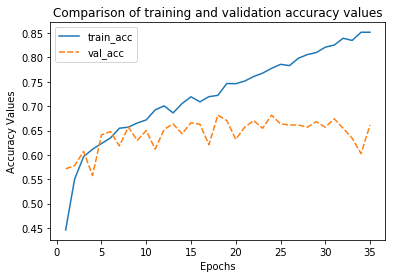

In [82]:
create_line_charts(create_acc_df(model_history_data3, 35), 'Comparison of training and validation accuracy values', 'Epochs', 'Accuracy Values')

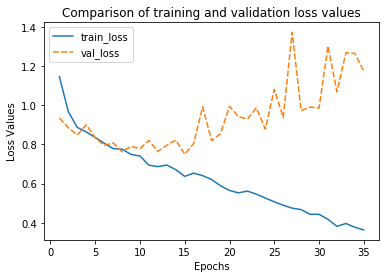

In [84]:
create_line_charts(create_loss_df(model_history_data3, 35), 'Comparison of training and validation loss values', 'Epochs', 'Loss Values')

In [85]:
test_generator3 = test_datagen3.flow_from_directory(test_dir, target_size=(256,256), batch_size=batch_size, class_mode='categorical')
test_loss3, test_accuracy3 = custom_model3.evaluate_generator(test_generator3, steps=test_steps)
print('test_loss', test_loss3)
print('test_accuracy', test_accuracy3)

Found 475 images belonging to 3 classes.
test_loss 1.3448061432157243
test_accuracy 0.5982142857142857
